# Data preprocessing

This notebook preprocessed all data provided on Kaggle into 1 dataframe that all models can be trained on.

## Imports

Installable:

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import pandas as pd

Local imports:

In [3]:
LOCAL_LIB_PATH = "../mvi/"
if LOCAL_LIB_PATH not in sys.path:
    sys.path.append(LOCAL_LIB_PATH)

In [4]:
import mvi.utils as mvi_utils

## Config

In [5]:
SAVE_DATA = False

In [6]:
VALIDATE_SIZE = 0.3

In [7]:
DATA_DIR_PATH = "../data/"

PATH_RAW = os.path.join(DATA_DIR_PATH, "train_join.csv")
PATH_PREPROCESSED_TRAIN = os.path.join(DATA_DIR_PATH, "train_preprocessed.csv")
PATH_PREPROCESSED_TEST = os.path.join(DATA_DIR_PATH, "test_preprocessed.csv")

## Read data

In [8]:
def _read_data(path: str) -> pd.DataFrame:
    return pd.read_csv(path, parse_dates=["timestamp"])

In [9]:
df_raw = _read_data(PATH_RAW)
display(df_raw.head(1))

id  price_doc  timestamp  full_sq  life_sq  floor  max_floor  material  \
0  29    8254400 2011-09-26       73     38.0   15.0        NaN       NaN   

   build_year  num_room  kitch_sq  state    cpi  employment   salary  \
0         NaN       NaN       NaN    NaN  353.2       0.708  44898.7   

   salary_growth  deposits_value  mortgage_rate  
0       0.168917        10920215          11.92

Column types:

In [10]:
COLS_IGNORE = [
    "id",
    "timestamp",
]

COLS_CAT = [
    "material",
    "state",
]

COLS_CONT = [col for col in df_raw if col not in COLS_CAT + COLS_IGNORE]
COLS_CONT

['price_doc',
 'full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'build_year',
 'num_room',
 'kitch_sq',
 'cpi',
 'employment',
 'salary',
 'salary_growth',
 'deposits_value',
 'mortgage_rate']

## Preprocessing steps definition

Handling NaNs:

In [11]:
def _fill_missing_median(df: pd.DataFrame) -> pd.DataFrame:
    """Fills missing values with its median"""
    cols_fill = [col for col in COLS_CONT if col in df.columns]
    means = df.loc[:, cols_fill].mean(numeric_only=True)
    df.loc[:, cols_fill] = df.loc[:, cols_fill].fillna(means) 
    
    return df
    
    
def _factorize_categorcical(df: pd.DataFrame) -> pd.DataFrame:
    cols_fac = [col for col in COLS_CAT if col in df.columns]
    for col in cols_fac:
        df.loc[:, col], _ = pd.factorize(df.loc[:, col], sort=True)
        
    return df

In [12]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocessed the dataframe using pre-defined steps"""
    return (df
            .transform(_fill_missing_median)
            .transform(_factorize_categorcical)
           )

In [13]:
df_filled = preprocess_data(df_raw)

## Remove outliers

In [14]:
def _plot_main_components(df: pd.DataFrame) -> None:
    """Plots two main components of the dataset"""
    df_plot = df.drop(COLS_IGNORE, axis=1)
    mvi_utils.get_pca(df_plot)

In [15]:
def _remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Removes outliers"""
    return mvi_utils.remove_outliers_zscore(df, cols_ignore=COLS_IGNORE)

Main 2 components before:

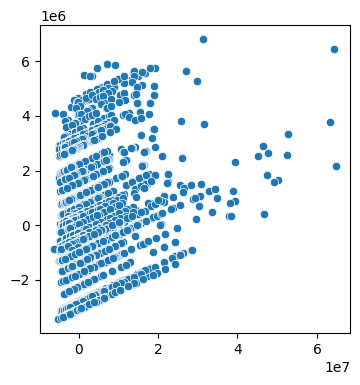

In [16]:
_plot_main_components(df_filled)

In [17]:
df_out_removed = _remove_outliers(df_filled)

[zscore] Number of removed samples: 1472 / 11023 ~ 13.35%


Main 2 components after:

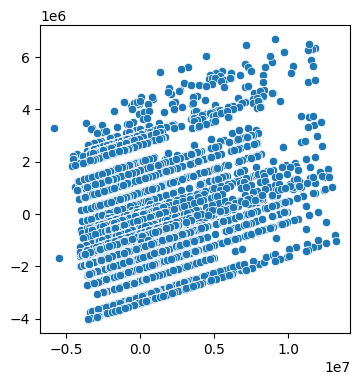

In [18]:
_plot_main_components(df_out_removed)

## Separate 

Separate into train / test sets

In [19]:
def _train_test_split(df: pd.DataFrame): 
    """Splits a DF into two new mutually exclusive DFs"""
    df_test = df.sample(frac=VALIDATE_SIZE, random_state=21)
    df_train = df.drop(df_test.index)
    
    return df_train, df_test

In [20]:
df_train, df_test = _train_test_split(df_out_removed)

## Save result

In [21]:
def save_data_csv(df: pd.DataFrame, path: str) -> None:
    """Saves the dataframe as CSV"""
    print(f"Saving {df.shape[0]:,} rows to path: {path}")
    df.to_csv(path, index=False)

In [22]:
if not SAVE_DATA:
    save_data_csv(df_train, PATH_PREPROCESSED_TRAIN)
    save_data_csv(df_test, PATH_PREPROCESSED_TEST)

Saving 6,686 rows to path: ../data/train_preprocessed.csv
Saving 2,865 rows to path: ../data/test_preprocessed.csv
